# Fine tune LLM: From Causal Model to a Chatbot

Author: Zairen Zhu, Zhengwei Zhang, Borui Cai

## Introduction

In this project, we will implement two fine tuning method on a base model, and compare The result and difference.

## Basic Configuration

Befor we start, 
- install all the requirements in `./requirements.txt`. 
- run the following cell to import packages and log in to hugging face. You need to apply a token [here](https://huggingface.co/settings/tokens)
- Check the output of the following cells. A CUDA device is highly recommended.

In [ ]:
! pip install -U torch transformers accelerate datasets evaluate accelerate timm bitsandbytes accelerate

In [ ]:
from huggingface_hub import notebook_login, whoami
from pprint import pprint
import torch
from datasets import load_dataset, DatasetDict
try: 
    whoami()['fullname'] is not None
    print('Logged in as ', whoami()['fullname'])
    print('You have access to the models and datasets.\nGo on the next cell to load the dataset and model.')
except: 
    print('input token in the following comment to get access to the models and datasets')
    notebook_login()

from transformers import __version__
print(f"Transformers version: {__version__}")
device = torch.device("mps" if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Logged in as  Tianlu
You have access to the models and datasets.
Go on the next cell to load the dataset and model.
Transformers version: 4.52.4
Using device: cuda


## Load a causal model

Then we load a causal model form `EleutherAI/pythia-1.4b`. This is a causal model, which designed for investigating how large language models evolve during training. We choose 1.4b parameter for a balance of performance and limited calculation resource.

So let's download this model and load it.

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer
checkpoint = "EleutherAI/pythia-1.4b"

model = AutoModelForCausalLM.from_pretrained(checkpoint, torch_dtype=torch.bfloat16, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(checkpoint,)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


We want to see how this model perform on a basic science problem. So run on next cell to see it response:

In [4]:
# To test the model with a question
testcase = '''
Which of the following is produced during the process of cellular respiration?  Choices are:  sodium chloride, oxygen, sugar, carbon dioxide,
'''
model_inputs = tokenizer(testcase, return_tensors="pt").to(device)

generated_ids = model.generate(**model_inputs, max_new_tokens=64,)
print(tokenizer.batch_decode(generated_ids, skip_special_tokens=False)[0])
# summarize the output, and state why we need to fine-tune the model

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.



Which of the following is produced during the process of cellular respiration?  Choices are:  sodium chloride, oxygen, sugar, carbon dioxide,

A:

The answer is:

sodium chloride

The process of cellular respiration is:

sodium chloride is oxidized to sodium hydroxide
sodium hydroxide is oxidized to sodium carbonate
sodium carbonate is oxidized to sodium bicarbonate
sodium bicarbonate is oxidized to carbon dioxide


Unfortunately, the model does not answer the question. It is because the nature of a causal model: always predict following words, but not having a sence to answer question. 

This example response shows the necessary of **fine tuning a model to a chatbot**, because without fine tuning, it can just repeat your prompts.

## Load training data and formatted

Here we load `ARC-Easey`, a subset from `allenai/ai2_arc`, including elementary-level science questions. Each example in the raw dataset consists of a question a set of multiple-choice options, and the correct answer key like 'A', 'B', C or 'D'.

For better training, we combine train and test set as train set, and rename the validation set as test set.

In [5]:
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling
from datasets import load_dataset, DatasetDict, concatenate_datasets

arc = load_dataset('allenai/ai2_arc','ARC-Easy')
# Combine train and test sets into new train set, use validation as test set
combined_train = concatenate_datasets([arc['train'], arc['test']])
arc = DatasetDict({
    'train': combined_train,
    'test': arc['validation']
})

Take a look at the size of dataset, features of data and a example.

In [6]:
display('train set size:', len(arc['train']))
display('test set size:', len(arc['test']))
display(arc['train'].features)
display(arc['train'][289])

'train set size:'

4627

'test set size:'

570

{'id': Value(dtype='string', id=None),
 'question': Value(dtype='string', id=None),
 'choices': Sequence(feature={'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, length=-1, id=None),
 'answerKey': Value(dtype='string', id=None)}

{'id': 'WASL_2003_5_9',
 'question': 'Which object below is gaining stored energy?',
 'choices': {'text': ['A rubber band that is being stretched',
   'A battery in a flashlight that is on',
   'A candle that is burning'],
  'label': ['A', 'B', 'C']},
 'answerKey': 'A'}

Then we format this structured data into plain text, and notate the instruction and response in the following way:

```
### Instruction:
[Question text] Choices are: [List of choices, comma-separated] 
 
### Response:
[Correct Answer text]
```

Run the next cell, we format this dataset, and take a look at one example.

In [7]:
def to_format(example: DatasetDict):
    question = example['question']
    choices: list[str] = example['choices']['text']
    answerKey = example['answerKey']
    answer = choices[ord(answerKey)- (ord('A') if example['answerKey'].isupper() else ord('1'))]
    choices_str = ' Choices are: ' + choices[0] + ', ' + choices[1] + ', ' + choices[2] + ', ' + choices[3] if len(choices) > 3 else '.'
    return {
        'text': f"### Instruction:\n {question} {choices_str} \n\n ### Response:\n {answer} \n"
    }

arc_formatted = arc.map(to_format)

pprint(arc_formatted['train'][289]['text'])

('### Instruction:\n'
 ' Which object below is gaining stored energy? . \n'
 '\n'
 ' ### Response:\n'
 ' A rubber band that is being stretched \n')


The next thing is to filter examples not too long (over 500 characters). It helps to reduce the useless padding marker in training, then improve training efficiency.

Run the next cell, we filter examples ans display the number of examples remaining.

In [8]:

def filter_short(example: DatasetDict):
    texts = example['text']
    return [len(text) <= 500 for text in texts]
arc_formatted = arc_formatted.filter(filter_short, batched=True)
display(f'number of examples after filtering: {len(arc_formatted['train'])}', )
display(f'number of examples after filtering: {len(arc_formatted['test'])}', )

'number of examples after filtering: 4370'

'number of examples after filtering: 541'

Only about 6% examples are filtered out, so it do not significantly reduce the number of cases.

In the next cell, we randomly choose 10 examples from test set for a evaluation after fine tuning.

In [9]:
from numpy import random
testcase = list()
random.seed(46)
for _ in range(10):
    i = random.randint(0, len(arc_formatted['test']) - 1)
    text = arc_formatted['test'][i]['text']
    prompt = text.split('### Response:')[0].strip() + '\n### Response:'
    answer = text.split('### Response:')[1].strip()
    testcase.append({
        'prompt': prompt,
        'answer': answer
    })

## Tokenization and labelling

Codes in the next cell are a little bit complex. Overally, we create three new list for each example, that is `input_ids`, `labels` and `attention_mask`.

- `input_ids`: Numerical representation of the input text.
    - Generated by the Pythia tokenizer.
    - Fixed length (128 tokens) by truncating or padding with token 0.

- `labels`: The target tokens the model should predict during training.
    - Typically shifted input tokens for causal models.
    - **Crucially**, masked (-100) for tokens *before* the `### Response:` marker.
    - Masked (-100) for *padding* tokens *after* the response.
    - Loss is calculated *only* on non -100 labels, focusing learning on the response part.

- `attention_mask`: Indicates which tokens are actual content.
    - Binary mask (1 for content, 0 for padding).
    - Tells the model to ignore padding tokens.

Here is an visuallized example of how it works.

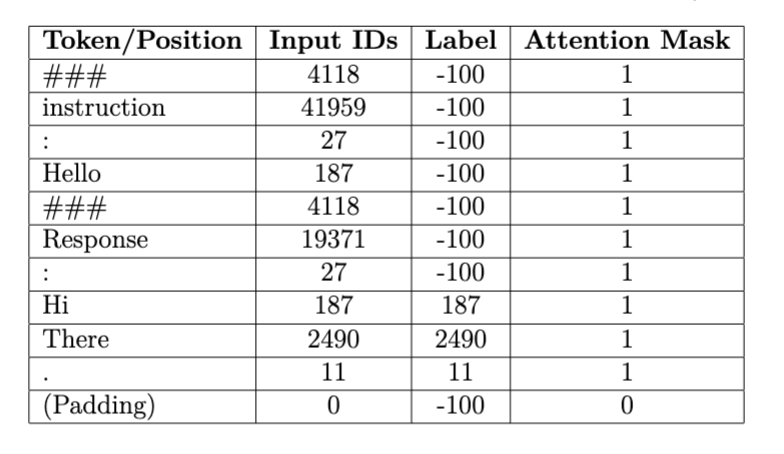


In [10]:
response_template = ' ### Response:\n'
response_template_ids = tokenizer.encode(response_template, add_special_tokens=False)
response_template_ids_len = len(response_template_ids)

def add_labels(example: DatasetDict):
    tokenized_inputs = tokenizer(
        example['text'],
        truncation=True,
        max_length=256,
        padding='max_length',
    )

    labels = tokenized_inputs['input_ids'].copy()
    # display(labels)
    index = -1
    for i in range(len(labels) - response_template_ids_len + 1):
        if labels[i:i + response_template_ids_len] == response_template_ids:
            index = i + response_template_ids_len
            break
    assert index != -1, f"Response template not found in tokenized inputs.\n {example['text']}"
    labels[:index] = [-100] * index
    for i in range(index, len(labels)):
        if labels[i] == tokenizer.pad_token_id:
            labels[i] = -100
    tokenized_inputs['labels'] = labels
    return tokenized_inputs

arc_tokenized = arc_formatted.map(add_labels, remove_columns=['id','question','choices', 'answerKey', 'text'], batched =False)
# example = DatasetDict({'text': ['### Instruction:\nWhat is the capital of France?\n\n### Response:\n Paris.\n']})
# add_labels(example)
# example = arc_formatted['train'][368]
# pprint(f"Example text: {example['text']}")
# add_labels(example)
print(f"Number of examples: {len(arc_tokenized['train'])}")
print(f"Number of test examples: {len(arc_tokenized['test'])}")
arc_tokenized['train'].features

Number of examples: 4370
Number of test examples: 541


{'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

## Fine Tuning method 1: Full Parameter

The first method we try on here is full parameter fine tuning. In the next cell, we

- Set data collator
- Set training arguments,
  - Use epoch = 1 for time saving
  - Evaluate every 50 steps
- Train the model
- Save the model

In [12]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # Causal language model does not use MLM
)

In [13]:
training_args = TrainingArguments(
    output_dir="./arc-finetuned",
    learning_rate=2e-6,
    per_device_train_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    remove_unused_columns=False,
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=50,
    save_total_limit=2,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=arc_tokenized['train'],
    eval_dataset=arc_tokenized['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()
trainer.save_model("./arc-finetuned")


C:\Users\Zhengwei\AppData\Local\Temp\ipykernel_52848\1204245298.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
50,No log,2.946114
100,No log,2.470195
150,No log,2.165443
200,No log,2.041997
250,No log,1.993502
300,No log,1.965072
350,No log,1.954453
400,No log,1.948004
450,No log,1.951312
500,2.132500,1.950860


Training time elapse: 1:25:36 for 1 epoch in cpu AMD Ryzen 9900X 12 cores 24 threads. 

In Cuda with GPU Nvidia RTX 4080 Super, time elapse: 7:57. We will compare this time with another method of fine tuning.

### Inference the model with full parameter fine tuned

Next, we will test this model on testcases we create before. In next cell, we load the data and run the evaluation. 

In [14]:

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
model_dir = "./arc-finetuned"
try:
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    print(f"Tokenizer loaded from {model_dir}")
except Exception as e:
    print(f"Error loading tokenizer from {model_dir}: {e}")
    print("Please ensure the directory contains tokenizer files (e.g., tokenizer_config.json, vocab.json).")
    exit()
print(f"Using device: {device}")
try:
    model = AutoModelForCausalLM.from_pretrained(model_dir).to(device)
    model.eval()
    print(f"Model loaded from {model_dir} and moved to {device}")
except Exception as e:
    print(f"Error loading model from {model_dir}: {e}")
    print("Please ensure the directory contains model files (e.g., config.json, pytorch_model.bin).")
    exit()

def generate_response(prompt, input_text=None, max_new_tokens=32):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    prompt_length = input_ids.shape[1]
   
    generated_ids = model.generate(
        input_ids,
        max_new_tokens=max_new_tokens, 
        num_beams=1,  
        do_sample=False,             
        pad_token_id=tokenizer.eos_token_id, 
        eos_token_id=tokenizer.eos_token_id  
    )
    generated_response_ids = generated_ids[0][prompt_length:]
    response = tokenizer.decode(generated_response_ids, skip_special_tokens=True).strip()
    response = response.split('\n')[0].strip()
    return response
print("\n--- start inference ---")


Tokenizer loaded from ./arc-finetuned
Using device: cuda
Model loaded from ./arc-finetuned and moved to cuda

--- start inference ---


In [15]:

for i in range(len(testcase)):
    prompt = testcase[i]['prompt']
    answer = testcase[i]['answer']
    pprint(f"Case {i+1}: {prompt}")
    print(f"Expected Answer: {answer}")
    response = generate_response(prompt)
    print(f"Generated Response: {response}")
    print("-" * 30)


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


('Case 1: ### Instruction:\n'
 ' Energy from the Sun changes ocean water to a gas. This sentence describes '
 'which step in the water cycle?  Choices are: condensation, evaporation, '
 'precipitation, runoff\n'
 '### Response:')
Expected Answer: evaporation
Generated Response: evaporation
------------------------------
('Case 2: ### Instruction:\n'
 ' Sonar helps people find which information about an object?  Choices are: '
 'Color, Weight, Location, Temperature\n'
 '### Response:')
Expected Answer: Location
Generated Response: Color
------------------------------
('Case 3: ### Instruction:\n'
 ' After rubbing a rubber brush on wool, Gilbert is able to use the brush to '
 'pick up small strips of paper. What causes the paper to be attracted to the '
 'brush?  Choices are: gravity, electric current, static electricity, '
 'magnetism\n'
 '### Response:')
Expected Answer: static electricity
Generated Response: electric current
------------------------------
('Case 4: ### Instruction:\n'

4/10 questions are answered correctly. And we can see that, model have a strong intention to try on answering these problem, even though some are wrong.

## Fine Tuning Method 2: LoRA

In this part, we will focus on LoRA fine tuning. It will only adjust some parameters, but not all. So usually LoRA would be more efficient.

In next cell, we set the arguments of training, run this fine tuning, and save the model.

***IMPORTANT***

Before run the next cell for training, ensure your GPU memory is released and avaliable. If not, restart python kernel and run all the preparation works again.


In [11]:
from peft import LoraConfig, get_peft_model, TaskType
import gc
import torch

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # Causal language model does not use MLM
)

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
model = AutoModelForCausalLM.from_pretrained(checkpoint, torch_dtype=torch.bfloat16, device_map="auto")

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query_key_value", "dense"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()
lora_training_args = TrainingArguments(
    output_dir="./arc-finetuned-lora",
    learning_rate=2e-6,
    per_device_train_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    remove_unused_columns=False,
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=500,
    save_steps=500,
    save_total_limit=2,
    load_best_model_at_end=True,
    warmup_ratio=0.03,
)

lora_trainer = Trainer(
    model=model,
    args=lora_training_args,
    train_dataset=arc_tokenized['train'],
    eval_dataset=arc_tokenized['test'],
    processing_class=tokenizer,
    data_collator=data_collator,
)

lora_trainer.train()
lora_trainer.save_model("./arc-finetuned-lora")

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 2,359,296 || all params: 1,417,007,104 || trainable%: 0.1665


Step,Training Loss,Validation Loss
500,3.021100,2.530103
1000,2.067100,1.938576
1500,1.819500,1.846228
2000,1.776300,1.815563
2500,1.755300,1.805384


Time elapse: 10:14 for 5 epochs. This is much faster than full parameter fine tuning, so we train it with more epochs.

### Inference the model with LoRA

Similarly, we load the lora model and inference with testcases for evaluation.

In [12]:

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
model_dir = "./arc-finetuned-lora"
try:
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    print(f"Tokenizer loaded from {model_dir}")
except Exception as e:
    print(f"Error loading tokenizer from {model_dir}: {e}")
    print("Please ensure the directory contains tokenizer files (e.g., tokenizer_config.json, vocab.json).")
    exit()

print(f"Using device: {device}")


try:
    model = AutoModelForCausalLM.from_pretrained(model_dir).to(device)
    model.eval()
    print(f"Model loaded from {model_dir} and moved to {device}")
except Exception as e:
    print(f"Error loading model from {model_dir}: {e}")
    print("Please ensure the directory contains model files (e.g., config.json, pytorch_model.bin).")
    exit() 

def generate_response(prompt, input_text=None, max_new_tokens=32):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    prompt_length = input_ids.shape[1]
    generated_ids = model.generate(
        input_ids,
        max_new_tokens=max_new_tokens,
        num_beams=1,      
        do_sample=False,            
        pad_token_id=tokenizer.eos_token_id, 
        eos_token_id=tokenizer.eos_token_id  
    )
    
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    generated_response_ids = generated_ids[0][prompt_length:]
    response = tokenizer.decode(generated_response_ids, skip_special_tokens=True).strip()
    response = response.split('\n')[0].strip()
    return response

Tokenizer loaded from ./arc-finetuned-lora
Using device: cuda
Model loaded from ./arc-finetuned-lora and moved to cuda


In [13]:
print("\n--- start inference ---")
for i in range(len(testcase)):
    prompt = testcase[i]['prompt']
    answer = testcase[i]['answer']
    pprint(f"Case {i+1}: {prompt}")
    print(f"Expected Answer: {answer}")
    response = generate_response(prompt)
    print(f"Generated Response: {response}")
    print("-" * 30)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



--- start inference ---
('Case 1: ### Instruction:\n'
 ' Energy from the Sun changes ocean water to a gas. This sentence describes '
 'which step in the water cycle?  Choices are: condensation, evaporation, '
 'precipitation, runoff\n'
 '### Response:')
Expected Answer: evaporation
Generated Response: evaporation
------------------------------
('Case 2: ### Instruction:\n'
 ' Sonar helps people find which information about an object?  Choices are: '
 'Color, Weight, Location, Temperature\n'
 '### Response:')
Expected Answer: Location
Generated Response: Color
------------------------------
('Case 3: ### Instruction:\n'
 ' After rubbing a rubber brush on wool, Gilbert is able to use the brush to '
 'pick up small strips of paper. What causes the paper to be attracted to the '
 'brush?  Choices are: gravity, electric current, static electricity, '
 'magnetism\n'
 '### Response:')
Expected Answer: static electricity
Generated Response: magnetism
------------------------------
('Case 4: #

3/10 answers are right.

## Conclusion

Compared with full parameter fine tuning, LoRA have 3 times efficiency in training and similarly outcome.

Due to the small size of this base model, it is hard to improve the scores in testcases, but this experimentation still shows the improvement of a fine tuning work: make the model answering question, but not response something else.

## References

- [Fine-tuning Tutorial by Huggingface](https://huggingface.co/docs/transformers/en/training)
- [LoRA Tutorial by Huggingface](https://huggingface.co/docs/diffusers/en/training/lora)
- Biderman, Stella, et al. "Pythia: A suite for analyzing large language models across training and scaling." International Conference on Machine Learning. PMLR, 2023.
- Ding, Ning, et al. "Parameter-efficient fine-tuning of large-scale pre-trained language models." Nature Machine Intelligence 5.3 (2023): 220-235.
- Clark, Peter, et al. "Think you have solved question answering? try arc, the ai2 reasoning challenge." arXiv preprint arXiv:1803.05457 (2018).